# Домашнее задание №1: RL с блекджеком и Дастином Хоффманом

In [41]:
import bj
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

sns.color_palette("husl", 9)
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (16, 5)

In [42]:
def plot_results(results, N):
    print("Total reward: ", results[0], "Average reward: ", results[1][-1])

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    line = ax.plot(np.arange(N), results[1], label="Average reward", color="C0")
    ax.legend(loc="lower right")
    ax.set_ylabel("Average reward")   
        
def plot_grid(results, N):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    for i, (key, eps_dict) in enumerate(results.items()):
        plt.plot(np.mean(np.array(list(eps_dict.values())), axis=0), label=key, color="C%d" % i)

    ax.legend(loc="upper right")
    ax.set_xlabel("Games count")
    ax.set_ylabel("Result by gamma")

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    for i, eps in enumerate(np.linspace(0., 0.5, 6)):
        array = [list(eps_dict.values())[i] for eps_dict in results.values()]
        plt.plot(np.mean(np.array(array), axis=0), label=round(eps,1), color="C%d" % i)

    ax.legend(loc="upper right")
    ax.set_xlabel("Games count")
    ax.set_ylabel("Result by eps") 
    
def convert_state(state):
    return (state[0] - 4, state[1] - 1, int(state[2]))  

def play(env, pi, max_iter):
    env.seed(1)
    total_reward = 0
    avg_reward = [0]
    for i in tqdm(range(max_iter)):
        obs, _ = env.reset()
        state = convert_state(obs)
        done = False
        while not done:
            action = pi[state]
            obs, reward, done, *_ = env.step(action)
            state = convert_state(obs)
            if done:
                total_reward += reward
                avg_reward.append((avg_reward[-1] * i + reward) / (i + 1))
    return total_reward, avg_reward[1:]  

## Часть 1. BlackJack и стратегии

Базовая стратегия

In [43]:
nS = (28, 10, 2)
nA = 2

env = bj.BlackjackEnv(natural=True)
pi = np.ones(nS, dtype=np.int8)
pi[15:, :, :] = 0

In [44]:
results = play(env, pi, 100_000)

100%|██████████| 100000/100000 [00:23<00:00, 4223.78it/s]


In [45]:
print(f'Средний выигрыш при использовании базовой стратегии {results[1][-1]:.6f}')

Средний выигрыш при использовании базовой стратегии -0.177305


Q_learning

In [46]:
def init_Q(q_size):
    end_state = (18, 19, 20, 21, 22, 23, 24, 25, 26, 27)
   
    Q = np.random.random(q_size)
    Q[end_state, :, :, :] = 0.    
    return Q

def get_action(pi, state, nA, eps):

    return pi[state] if np.random.rand() > eps else np.random.randint(nA)

def compute_policy_by_Q(Q, idx):
    return np.argmax(Q, axis=idx)    

def convert_state(state):
    return (state[0] - 4, state[1] - 1, int(state[2]))

def update_Q(Q, s, a, r, ns, alpha, gamma):
    Q[s][a] = Q[s][a] + alpha * (r + gamma * max(Q[ns]) - Q[s][a])


def Q_learning(env, max_iter, alpha, gamma, eps, nS, nA, disable=True):
    Q = init_Q(nS + (nA, ))
    pi = compute_policy_by_Q(Q, len(nS))

    avg_reward = [0]
    for i in tqdm(range(max_iter), disable=disable):       
        obs, _ = env.reset()
        state = convert_state(obs)
        next_action = get_action(pi, state, nA, eps)    
             
        done = False
        while not done:
            new_obs, reward, done, *_ = env.step(next_action)  
            new_state = convert_state(obs)
            next_action = get_action(pi, new_state, nA, eps) 
            update_Q(Q, state, next_action, reward, new_state, alpha, gamma)
            pi = compute_policy_by_Q(Q, len(nS))
            state = new_state
            if done:
                avg_reward.append((avg_reward[-1] * i + reward) / (i + 1))
    return pi, avg_reward[1:]

In [47]:
grid_alpha = defaultdict(list)
grid_gamma = defaultdict(list)
grid_eps = defaultdict(list)
for alpha in np.linspace(0.01, 0.2, 4):
    for gamma in np.linspace(0.5, 0.9, 5):
        for eps in np.linspace(0.1, 0.3, 3):
            pi, avg_reward = Q_learning(env, 100_000, alpha, gamma, eps, nS, nA)
            grid_alpha[alpha].append(avg_reward)
            grid_gamma[gamma].append(avg_reward)
            grid_eps[eps].append(avg_reward)
                

Text(0, 0.5, 'Result by eps')

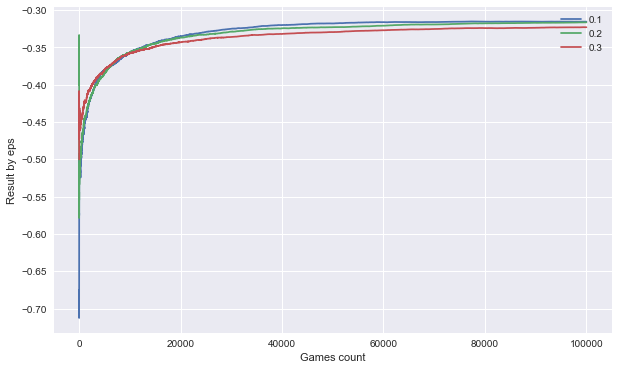

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i, eps in enumerate(np.linspace(0.1, 0.3, 3)):
    plt.plot(np.mean(np.array(grid_eps[eps]), axis=0), label=round(eps,1), color="C%d" % i)

ax.legend(loc="upper right")
ax.set_xlabel("Games count")
ax.set_ylabel("Result by eps") 

Text(0, 0.5, 'Result by gamma')

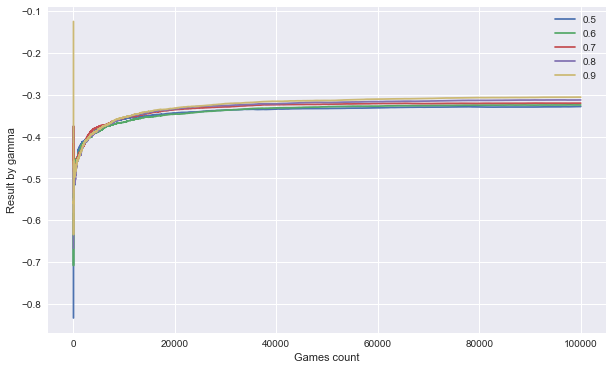

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i, gamma in enumerate(np.linspace(0.5, 0.9, 5)):
    plt.plot(np.mean(np.array(grid_gamma[gamma]), axis=0), label=round(gamma,1), color="C%d" % i)

ax.legend(loc="upper right")
ax.set_xlabel("Games count")
ax.set_ylabel("Result by gamma") 

Text(0, 0.5, 'Result by alpha')

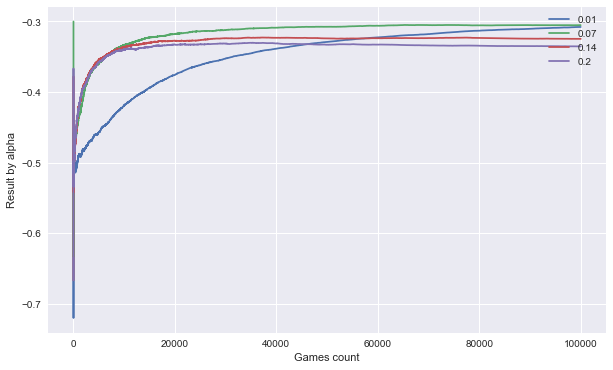

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i, alpha in enumerate(np.linspace(0.01, 0.2, 4)):
    plt.plot(np.mean(np.array(grid_alpha[alpha]), axis=0), label=round(alpha,2), color="C%d" % i)

ax.legend(loc="upper right")
ax.set_xlabel("Games count")
ax.set_ylabel("Result by alpha") 

In [51]:
print(f"Best parameters: alpha:0.07, gamma: 0.9, eps:0.1")

Best parameters: alpha:0.07, gamma: 0.9, eps:0.1


In [52]:
nS = (28, 10, 2)
nA = 2
env = bj.BlackjackEnv(natural=True)
pi, avg_reward = Q_learning(env, 100_000, 0.07, 0.9, 0.1, nS, nA, False)
results = play(env, pi, 100_000)

100%|██████████| 100000/100000 [00:21<00:00, 4642.54it/s]


In [53]:
print(f'Средний выигрыш при использовании q-learning {results[1][-1]:.6f}')

Средний выигрыш при использовании q-learning -0.116035


Monte-Carlo control off-policy

In [54]:
def init_Q(q_size):
    end_state = (18, 19, 20, 21, 22, 23, 24, 25, 26, 27)
   
    Q = np.random.random(q_size)
    Q[end_state, :, :, :] = 0.     
    return Q

def init_C(c_size):
    C = np.zeros(c_size)   
    return C

def get_action(pi, state, nA, eps):
    return pi[state] if np.random.rand() > eps else np.random.randint(nA)

def compute_policy_by_Q(Q, idx):
    return np.argmax(Q, axis=idx)    

def convert_state(state):
    return (state[0] - 4, state[1] - 1, int(state[2]))

def update_QC(Q, C, s, a, g, w):
    C[s][a] = C[s][a] + w
    Q[s][a] = Q[s][a] + (g - Q[s][a]) * w / C[s][a]


def update_policy(Q, C, pi, states, actions, rewards, nA, gamma, eps):
    G = 0.0
    W = 1.0
    proba = 1 - (nA - 1) * eps / nA
    update_QC(Q, C, states[-1], actions[-1], G, W)
    
    for k in range(len(states) - 2, -1, -1):
        if actions[k+1] != pi[states[k+1]]:
            break        
        W = W / proba 
        G =  G * gamma + rewards[k+1]
        update_QC(Q, C, states[k], actions[k], G, W)
 
    
def monte_carlo(env, max_iter, gamma, eps, nS, nA, disable=True):
    Q = init_Q(nS + (nA, ))
    C = init_C(nS + (nA, ))
    pi = compute_policy_by_Q(Q, len(nS))
    avg_reward = [0]
    
    for i in tqdm(range(max_iter), disable=disable):      
        obs, _ = env.reset()
        state = convert_state(obs)
        next_action = get_action(pi, state, nA, eps)    
        states, actions, rewards = [state], [next_action], [0]     
        done = False
        while not done:
            new_obs, reward, done, *_ = env.step(next_action)  
            new_state = convert_state(obs)
            states.append(new_state)
            next_action = get_action(pi, new_state, nA, eps) 
            actions.append(next_action)
            rewards.append(reward)
            update_policy(Q, C, pi, states, actions, rewards, nA, gamma, eps)
            pi = compute_policy_by_Q(Q, len(nS))
            state = new_state
            if done:
                avg_reward.append((avg_reward[-1] * i + reward) / (i + 1))
    return pi, avg_reward[1:]

In [55]:
nS = (28, 10, 2)
nA = 2
env = bj.BlackjackEnv(natural=True)

In [56]:
grid_gamma = defaultdict(list)
grid_eps = defaultdict(list)
for gamma in np.linspace(0.5, 0.9, 5):
    for eps in np.linspace(0.1, 0.5, 5):
        pi, avg_reward = monte_carlo(env, 100_000, gamma, eps, nS, nA, False)
        grid_gamma[gamma].append(avg_reward)
        grid_eps[eps].append(avg_reward)

100%|██████████| 100000/100000 [00:25<00:00, 3962.97it/s]


Text(0, 0.5, 'Result by eps')

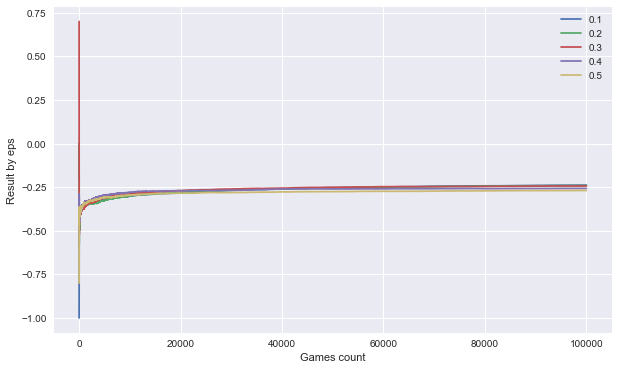

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i, eps in enumerate(np.linspace(0.1, 0.5, 5)):
    plt.plot(np.mean(np.array(grid_eps[eps]), axis=0), label=round(eps,1), color="C%d" % i)

ax.legend(loc="upper right")
ax.set_xlabel("Games count")
ax.set_ylabel("Result by eps") 

Text(0, 0.5, 'Result by gamma')

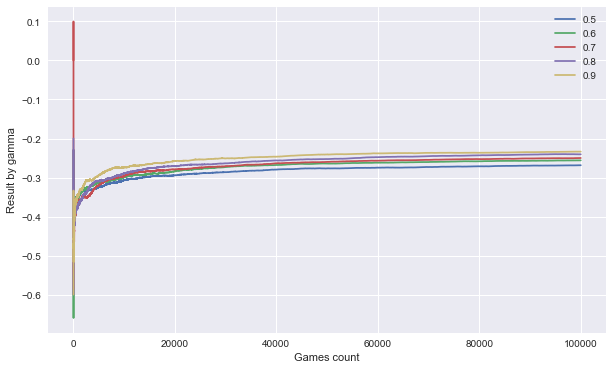

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i, gamma in enumerate(np.linspace(0.5, 0.9, 5)):
    plt.plot(np.mean(np.array(grid_gamma[gamma]), axis=0), label=round(gamma,1), color="C%d" % i)

ax.legend(loc="upper right")
ax.set_xlabel("Games count")
ax.set_ylabel("Result by gamma") 

In [59]:
print(f"Best parameters: gamma: 0.7, eps:0.4")

Best parameters: gamma: 0.7, eps:0.4


In [60]:
nS = (28, 10, 2)
nA = 2
env = bj.BlackjackEnv(natural=True)
pi, avg_reward = monte_carlo(env, 100_000, 0.7, 0.4, nS, nA, False)
results = play(env, pi, 100_000)

100%|██████████| 100000/100000 [00:21<00:00, 4705.10it/s]


In [61]:
print(f'Средний выигрыш при использовании monte-carlo {results[1][-1]:.6f}')

Средний выигрыш при использовании monte-carlo -0.141010


## Часть 2. Удвоение

In [62]:
nS = (28, 10, 3)
nA = 3

env = bj.DoubleBlackjackEnv(natural=True)

In [63]:
grid_gamma = defaultdict(list)
grid_eps = defaultdict(list)
for gamma in np.linspace(0.5, 0.9, 5):
    for eps in np.linspace(0.1, 0.5, 5):
        pi, avg_reward = monte_carlo(env, 100_000, gamma, eps, nS, nA, False)
        grid_gamma[gamma].append(avg_reward)
        grid_eps[eps].append(avg_reward)

100%|██████████| 100000/100000 [00:25<00:00, 3890.94it/s]


Text(0, 0.5, 'Result by eps')

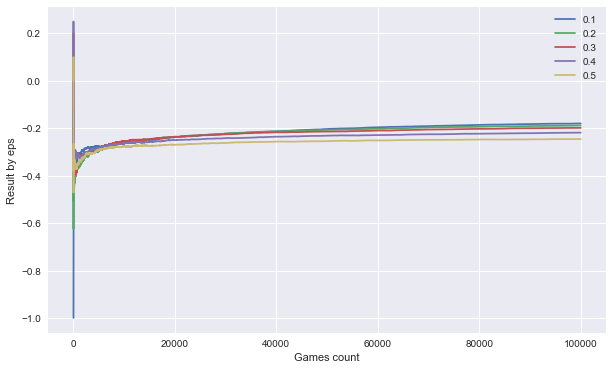

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i, eps in enumerate(np.linspace(0.1, 0.5, 5)):
    plt.plot(np.mean(np.array(grid_eps[eps]), axis=0), label=round(eps,1), color="C%d" % i)

ax.legend(loc="upper right")
ax.set_xlabel("Games count")
ax.set_ylabel("Result by eps") 

Text(0, 0.5, 'Result by gamma')

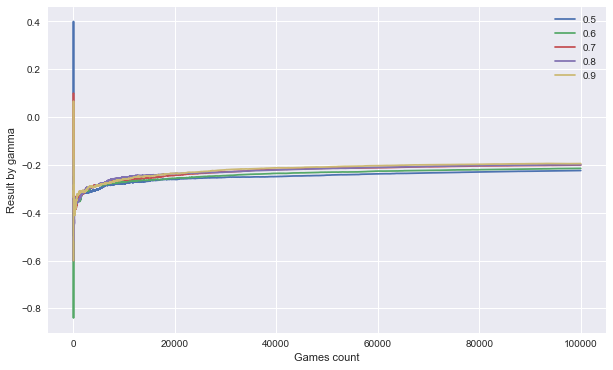

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i, gamma in enumerate(np.linspace(0.5, 0.9, 5)):
    plt.plot(np.mean(np.array(grid_gamma[gamma]), axis=0), label=round(gamma,1), color="C%d" % i)

ax.legend(loc="upper right")
ax.set_xlabel("Games count")
ax.set_ylabel("Result by gamma") 

In [66]:
print(f"Best parameters: gamma: 0.7, eps:0.4")

Best parameters: gamma: 0.7, eps:0.4


In [67]:
nS = (28, 10, 3)
nA = 3

env = bj.DoubleBlackjackEnv(natural=True)
pi, avg_reward = monte_carlo(env, 100_000, 0.9, 0.4, nS, nA, False)
results = play(env, pi, 100_000)

100%|██████████| 100000/100000 [00:21<00:00, 4554.42it/s]


In [68]:
print(f'Средний выигрыш при использовании monte-carlo {results[1][-1]:.6f}')

Средний выигрыш при использовании monte-carlo -0.066175


## Часть 3. Дастин Хоффман

In [69]:
def init_Q(q_size):
    end_state = (18, 19, 20, 21, 22, 23, 24, 25, 26, 27)
   
    Q = np.random.random(q_size)
    Q[end_state, :, :, :] = 0.     
    return Q

def init_C(c_size):
    C = np.zeros(c_size)   
    return C

def get_action(pi, state, nA, eps):
    return pi[state] if np.random.rand() > eps else np.random.randint(nA)

def compute_policy_by_Q(Q, idx):
    return np.argmax(Q, axis=idx)    

def convert_state(state):
    return (state[0] - 4, state[1] - 1, int(state[2]), state[3])

def update_QC(Q, C, s, a, g, w):
    C[s][a] = C[s][a] + w
    Q[s][a] = Q[s][a] + (g - Q[s][a]) * w / C[s][a]


def update_policy(Q, C, pi, states, actions, rewards, nA, gamma, eps):
    G = 0.0
    W = 1.0
    proba = 1 - (nA - 1) * eps / nA
    update_QC(Q, C, states[-1], actions[-1], G, W)
    
    for k in range(len(states) - 2, -1, -1):
        if actions[k+1] != pi[states[k+1]]:
            break        
        W = W / proba 
        G =  G * gamma + rewards[k+1]
        update_QC(Q, C, states[k], actions[k], G, W)
 
    
def monte_carlo(env, max_iter, gamma, eps, nS, nA, disable=True):
    Q = init_Q(nS + (nA, ))
    C = init_C(nS + (nA, ))
    pi = compute_policy_by_Q(Q, len(nS))
    avg_reward = [0]
    for i in tqdm(range(max_iter), disable=disable):      
        obs, _ = env.reset()
        state = convert_state(obs)
        next_action = get_action(pi, state, nA, eps)
        states, actions, rewards = [state], [next_action], [0]     
        done = False
        while not done:
            new_obs, reward, done, *_ = env.step(next_action)  
            new_state = convert_state(obs)
            states.append(new_state)
            next_action = get_action(pi, new_state, nA, eps) 
            actions.append(next_action)
            rewards.append(reward)
            update_policy(Q, C, pi, states, actions, rewards, nA, gamma, eps)
            pi = compute_policy_by_Q(Q, len(nS))
            state = new_state
            if done:
                avg_reward.append((avg_reward[-1] * i + reward) / (i + 1))
    return pi, avg_reward[1:]

In [70]:
nS = (28, 10, 3, 65)
nA = 3

env = bj.DoubleBlackjackEnvHiOpt(natural=True)

In [71]:
grid_gamma = defaultdict(list)
grid_eps = defaultdict(list)
for gamma in np.linspace(0.5, 0.9, 5):
    for eps in np.linspace(0.1, 0.5, 5):
        pi, avg_reward = monte_carlo(env, 100_000, gamma, eps, nS, nA, False)
        grid_gamma[gamma].append(avg_reward)
        grid_eps[eps].append(avg_reward)

100%|██████████| 100000/100000 [02:02<00:00, 817.91it/s]


Text(0, 0.5, 'Result by eps')

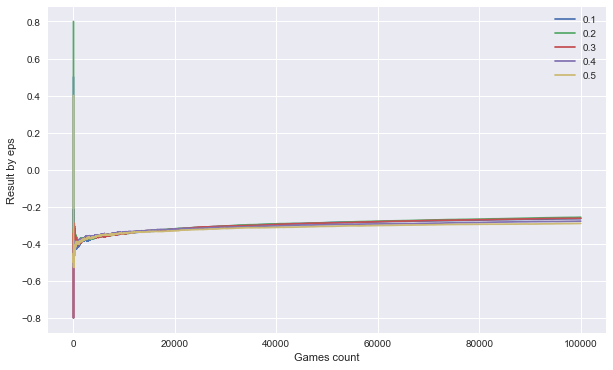

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i, eps in enumerate(np.linspace(0.1, 0.5, 5)):
    plt.plot(np.mean(np.array(grid_eps[eps]), axis=0), label=round(eps,1), color="C%d" % i)

ax.legend(loc="upper right")
ax.set_xlabel("Games count")
ax.set_ylabel("Result by eps") 

Text(0, 0.5, 'Result by gamma')

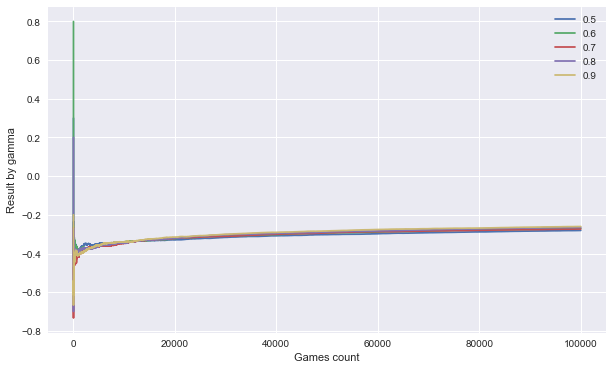

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i, gamma in enumerate(np.linspace(0.5, 0.9, 5)):
    plt.plot(np.mean(np.array(grid_gamma[gamma]), axis=0), label=round(gamma,1), color="C%d" % i)

ax.legend(loc="upper right")
ax.set_xlabel("Games count")
ax.set_ylabel("Result by gamma") 

In [74]:
print(f"Best parameters: gamma: 0.6, eps:0.2")

Best parameters: gamma: 0.6, eps:0.2


In [75]:
nS = (28, 10, 3, 65)
nA = 3

env = bj.DoubleBlackjackEnvHiOpt(natural=True)
pi, avg_reward = monte_carlo(env, 2_000_000, 0.6, 0.2, nS, nA, False)

100%|██████████| 2000000/2000000 [37:03<00:00, 899.61it/s] 


In [76]:
results = play(env, pi, 100_000)

100%|██████████| 100000/100000 [00:20<00:00, 4908.82it/s]


In [77]:
print(f'Средний выигрыш при использовании monte-carlo {results[1][-1]:.6f}')

Средний выигрыш при использовании monte-carlo -0.031715


С подсчетом карт получился лучший результат, но обыграть казино, к сожалению, не удалось